### **Import Libraries**

In [1]:
import os
import re
import psycopg2
import unicodedata
from datetime import datetime
from contextlib import contextmanager
from pydantic import BaseModel, Field
from typing import List, Dict, Sequence, TypedDict, Annotated, Literal, Optional

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage

### **Database Connection and Configuration**

In [2]:
# ================== Connect to Database ==================
DSN = os.getenv("DATABASE_URL")

@contextmanager
def get_db_connection():
  conn = psycopg2.connect(DSN)
  try:
    yield conn
  finally:
    conn.close()

# ================== Setup ORM types ==================
class MenuItems(BaseModel):
  id:                  Optional[int] = None
  title:               str
  price:               float
  image_url:           str
  description:         str
  main_category:       str
  sub_category:        Optional[str] = None
  
class Orders(BaseModel):
  id:                  Optional[int] = None
  customer_id:         str
  status:              str
  total_price:         float
  order_time:          datetime = Field(default_factory=datetime.now)

class OrderItems(BaseModel):
  id:                  Optional[int] = None 
  order_id:            int
  item_id:             int
  quantity:            int
  customizations:      str

### **SQL Query Syntax**

##### **1. Menu_items Table**

In [3]:
def getExactItem(item_name):
  """Return exact information of an item by its name"""
  try:
    with get_db_connection() as conn:
      with conn.cursor() as cur:
        cur.execute(
          """
          SELECT
            title, price, description
          FROM menu_items
          WHERE title = %s
          """, (item_name,)
        )
        row = cur.fetchone()
        return list(row)
  except Exception as e:
    return [f"Error: {e}", 0, ""]
  
def getSubCategories(main_cat):
  """Return exact information of an item by its name"""
  try:
    with get_db_connection() as conn:
      with conn.cursor() as cur:
        cur.execute(
          """
          SELECT 
            DISTINCT sub_category
          FROM menu_items
          WHERE main_category = %s
          """, (main_cat,)
        )
        rows = cur.fetchall()
        return [r[0] for r in rows if r[0] is not None]
  except Exception as e:
    return [f"Error: {e}"]
  
def getTopItemsFromMain(main_cat):
  """Recommend top 5 items from main category if it has no subcategories"""
  try:
    with get_db_connection() as conn:
      with conn.cursor() as cur:
        # Check if has subcategories
        cur.execute(
          """
          SELECT 
            COUNT(DISTINCT sub_category)
          FROM menu_items
          WHERE main_category = %s
          AND sub_category != 'NaN'
          """, (main_cat,)
        )
        count = cur.fetchone()[0]
        if count == 0:
          # No subcategories, return items directly
          cur.execute(
            """
            SELECT 
              title, price, description
            FROM menu_items
            WHERE main_category = %s
            ORDER BY RANDOM()
            LIMIT 5
            """, (main_cat,)
          )
          rows = cur.fetchall()
          rows = [list(r) for r in rows]
          return rows
        else:
          # Has subcategories, return them
          return getSubCategories(main_cat)
  except Exception as e:
    return [(f"Error: {e}", 0, "")]
  
def getTopItemsFromSub(sub_cat):
  """Recommend top 5 items from sub category"""
  try:
      with get_db_connection() as conn:
        with conn.cursor() as cur:
          cur.execute(
            """
            SELECT title, price, description
            FROM menu_items
            WHERE sub_category = %s
            ORDER BY RANDOM()
            LIMIT 5
            """, (sub_cat,)
          )
          rows = cur.fetchall()
          rows = [list(r) for r in rows]
          return rows
  except Exception as e:
    return [(f"Error: {e}", 0, "")]
  
def getMenuItemsByTitle(item_name: str) -> List[Dict]:
  try:
    with get_db_connection() as conn:
      with conn.cursor() as cur:
        cur.execute(
          """
          SELECT 
            id, title, price 
          FROM menu_items
          WHERE LOWER(title) = LOWER(%s)
          """, (item_name,)
        )
        rows = cur.fetchall()
        
        return [
          {
            "id": row[0],
            "title": row[1],
            "price": row[2]
          }
          for row in rows
        ]
  except Exception as e:
    print(f"Error fetching item by title: {e}")
    return []

##### **2. Order Table**

In [4]:
def insertOrder(orders: Orders) -> int:
  try:
    with get_db_connection() as conn:
      with conn.cursor() as cur:
        cur.execute(
          """
          INSERT INTO orders (
            customer_id, status, total_price, order_time
          ) VALUES (%s, %s, %s, %s)
          RETURNING id
          """,
          (
            orders.customer_id,
            orders.status,
            orders.total_price,
            orders.order_time
          )
        )
        order_id = cur.fetchone()[0]
        conn.commit()
        print(f"Insert order {order_id} successfully!")
        return order_id
  except Exception as e:
    print(f"Cannot insert order {id}, reason: {e}")
    raise
  
def updateOrderStatus(order_id: int, new_status: str) -> None:
  try:
    with get_db_connection() as conn:
      with conn.cursor() as cur:
        cur.execute(
          """
          UPDATE order SET status = %s WHERE id = order_id
          """, (new_status, order_id)
        )
        conn.commit()
  except Exception as e:
    print(f"Cannot update order status, reason: {e}")
    raise

def getOrderStatus(order_id: int) -> dict | None:
  try:
    with get_db_connection() as conn:
      with conn.cursor() as cur:
        cur.execute(
          """
          SELECT
            id, status, total_price
          FROM order
          WHERE id = %s
          """, (order_id,)
        )
        row = cur.fetchone()
        if row:
          return {
            "id": row[0],
            "status": row[1],
            "total_price": row[2]
          }
        return None
  except Exception as e:
    print(f"Cannot get order status, reason: {e}")
    return None

##### **3. Order_Items Table**

In [5]:
def insertOrderItem(item: OrderItems) -> None:
  try:
    with get_db_connection() as conn:
      with conn.cursor() as cur:
        cur.execute(
          """
          INSERT INTO order_items (
            order_id, item_id, quantity, customizations
          ) VALUES (%s, %s, %s, %s)
          """,
          (
            item.order_id,
            item.item_id,
            item.quantity,
            item.customizations
          )
        )
        conn.commit()
  except Exception as e:
    print(f"Cannot insert order item, reason: {e}")
    raise

### **Raw**

In [6]:
mappings = {
  'Cà phê': {
    'Cà phê máy': ['Latte Classic', 'Latte Bạc Xỉu', 'Latte Coconut', 'Latte Hazelnut', 'Latte Caramel', 'Latte Almond', 'Latte Nóng'],
    'Cà phê phin': ['Bạc Xỉu Foam Dừa', 'Bạc Xỉu Caramel Muối', 'Đường Đen Sữa Đá','Bạc Xỉu Nóng',
                    'Bạc Xỉu', 'Cà Phê Sữa Đá', 'Cà Phê Đen Đá', 'Cà Phê Sữa Nóng', 'Cà Phê Đen Nóng'],
    'Cold Brew': ['Cold Brew Kim Quất', 'Cold Brew Sữa Tươi', 'Cold Brew Truyền Thống'],
    'A-Mê': ['A-Mê Tuyết Quất', 'A-Mê Tuyết Mơ', 'A-Mê Tuyết Đào', 'A-Mê Quất', 'A-Mê Mơ', 'A-Mê Đào', 'A-Mê Classic', 'Americano Nóng'],
    'Espresso': ['Espresso Đá','Cappuccino Đá', 'Caramel Macchiato Đá', 'Cappuccino Nóng', 'Caramel Macchiato Nóng', 'Espresso Nóng']
  },

  'Thức uống đá xay': {
    'Đá xay': ['Frosty Cà Phê Đường Đen', 'Frosty Caramel Arabica', 'Frosty Bánh Kem Dâu', 'Frosty Phin-Gato', 'Frosty Trà Xanh',
                'Frosty Cà Phê Đường Đen', 'Frosty Caramel Arabica', 'Frosty Phin-Gato', 'Frosty Trà Xanh', 'Frosty Bánh Kem Dâu'],
    'Đá xay có lớp whipping cream': ['Frappe Choco Chip', 'Frappe Hazelnut', 'Frappe Caramel', 'Frappe Almond', 'Frappe Espresso', 'Frappe Coconut Coffee', 'Frappe Matcha'],
  },

  'Matcha': {
    '': ['Matcha Yuzu Đá Xay', 'Matcha Yuzu', 'Matcha Đào Đá Xay', 'Matcha Đào', 'Matcha Okinawa Trân Châu Hoàng Kim', 'Matcha Sữa Dừa Đá Xay', 'Matcha Sữa Dừa',
        'Matcha Latte', 'Matcha Tinh Khiết', 'Trà Xanh - Xinh Chẳng Phai', 'Trà Xanh - Yêu Chẳng Phai', 'Matcha Latte Tây Bắc Sữa Yến Mạch', 'Trà Xanh Tây Bắc',
        'Matcha Latte Tây Bắc Sữa Yến Mạch (Nóng)', 'Trà Xanh Nước Dừa', 'Trà Xanh Nước Dừa Yuzu', 'Matcha Latte Tây Bắc (Nóng)', 'Matcha Latte Tây Bắc']
  },

  'Trà trái cây - Hi Tea': {
    'Hi Tea': ['Hi-Tea Yuzu Kombucha', 'Hi-Tea Đào Kombucha', 'Hi-Tea - Xinh Chẳng Phai', 'Hi-Tea Đào', 'Hi-Tea Vải', 'Hi-Tea Yuzu Trân Châu', 'Hi-Tea - Yêu Chẳng Phai',
                'Hi-Tea Đá Tuyết Mận Muối Trân Châu', 'Hi-Tea Dâu Tây Mận Muối Trân Châu', 'Hi-Tea Kim Quất Bưởi Hồng Mandarin', 'Dâu Phô Mai'],
    'Trà trái cây': ['Oolong Tứ Quý Sen',  'Oolong Tứ Quý Sen (Nóng)', 'Oolong Tứ Quý Dâu Trân Châu', 'Oolong Tứ Quý Vải',
                      'Oolong Tứ Quý Kim Quất Trân Châu', 'Trà Đào Cam Sả - Nóng', 'Trà Đào Cam Sả - Đá', 'Oolong Berry']
  },

  'Trà sữa': {
    '': ['Trà sữa Oolong Nướng Trân Châu', 'Trà Đen Macchiato', 'Hồng Trà Sữa Trân Châu', 'Hồng Trà Sữa Nóng',
        'Trà Sữa Oolong Tứ Quý Sương Sáo', 'Trà Sữa Oolong Nướng Sương Sáo','Trà Đào - Yêu Chẳng Phai',
        'Trà Sữa Oolong BLao', 'Trà sữa Oolong Nướng (Nóng)', 'Chocolate Nóng', 'Chocolate Đá']
  },

  'Bánh': {
    'Bánh ngọt': ['Mochi Kem Trà Sữa Trân Châu', 'Mochi Kem Matcha', 'Mochi Kem Chocolate', 'Mochi Kem Việt Quất', 'Mochi Kem Phúc Bồn Tử',
                  'Mousse Matcha', 'Mousse Tiramisu', 'Mousse Gấu Chocolate', 'Matcha Burnt Cheesecake', 'Burnt Cheesecake', 'Mít Sấy', 'Butter Croissant Sữa Đặc'],
    'Bánh mặn': ['Bánh Mì Que Bò Nấm Xốt Bơ', 'Bánh Mì Que Chà Bông Phô Mai Bơ Cay', 'Bánh Mì Que Pate Cột Đèn', 'Chà Bông Phô Mai', 'Croissant trứng muối', 'Butter Croissant']
  },

  'Đồ ăn chế biến': {
    '': ['Spaghetti Bò Bằm', 'Cơm Chiên Hải Sản']
  },

  'Cà phê gói mang đi': {
    '': ['Cà Phê Đen Đá Túi (30 gói x 16g)', 'Cà Phê Đen Đá Hộp (14 gói x 16g)', 'Cà Phê Hoà Tan Đậm Vị Việt (18 gói x 16 gam)',
        'Cà Phê Sữa Đá Hòa Tan Túi 25x22G', 'Cà Phê Rang Xay Original 1 250G', 'Cà Phê Sữa Đá Hòa Tan (10 gói x 22g)', 'Cà Phê Nguyên Hạt Arabica TCH (200gr)']
  }
}

In [7]:
class QueryClassifier:
  def __init__(self, mappings):
    self.mappings = mappings
    self.main_cats, self.sub_cats, self.items = self.build_lookup_tables()
    
  def normalize_text(self, text):
    # Convert Vietnamese to accent-free + lowercase for robust matching
    text = unicodedata.normalize('NFD', text)
    text = ''.join(ch for ch in text if unicodedata.category(ch) != 'Mn')
    return text.lower().strip()

  def build_lookup_tables(self):
    main_cats, sub_cats, items = set(), set(), set()
    for main_cat, subs in self.mappings.items():
      main_cats.add(main_cat)
      for sub_cat, drinks in subs.items():
        if sub_cat:
          sub_cats.add(sub_cat)
        for drink in drinks:
          items.add(drink)
    return main_cats, sub_cats, items

  def classify_query(self, query):
    query_norm = self.normalize_text(query)

    # Normalize all names for comparison
    norm_main = {self.normalize_text(c): c for c in self.main_cats}
    norm_sub = {self.normalize_text(c): c for c in self.sub_cats}
    norm_items = {self.normalize_text(i): i for i in self.items}

    # Exact beverage (title) match
    for norm_name, original in norm_items.items():
      if norm_name in query_norm:
        return {"type": "item", "keyword": original}

    # Sub-category match
    for norm_name, original in norm_sub.items():
      if re.search(rf"\b{re.escape(norm_name)}\b", query_norm):
        return {"type": "sub_category", "keyword": original}

    # Main category match
    for norm_name, original in norm_main.items():
      if re.search(rf"\b{re.escape(norm_name)}\b", query_norm):
        return {"type": "main_category", "keyword": original}

    return {"type": "unknown", "keyword": None}

### **Tools for Agent**

In [8]:
@tool
def hand_customer_query(query: str) -> list[str]:
  """
  Search the menu to find drinks or food based on customer requests.
  Use this tool when customers ask about what's available, want recommendations,
  or ask about specific items.
  """
  qc = QueryClassifier(mappings)
  classification = qc.classify_query(query)
  
  if classification["type"] == "item":
    return getExactItem(classification["keyword"])

  elif classification["type"] == "sub_category":
    return getTopItemsFromSub(classification["keyword"])

  elif classification["type"] == "main_category":
    return getTopItemsFromMain(classification["keyword"])

  else:
    return ["Tôi chưa hiểu bạn muốn uống gì. Bạn có thể mô tả rõ hơn không?"]
  
@tool 
def place_order(customer_id: str, items: List[Dict]) -> str:
  """
  Place a new order after customer confirms all details.
  ONLY use this tool when the customer explicitly confirms the order.
  
  Args:
    customer_id: The customer's ID (provided in system context)
    items: List of items with details, e.g.:
        [
          {
            "item_name": "Cà phê sữa đá",
            "quantity": 2,
            "customizations": {
              "size": "L",
              "ice": "50%",
              "sugar": "70%",
              "milk_type": "oat milk"
            }
          }
        ]
    
  Returns:
    Confirmation message with order ID and total price
  """
  try:
    # Step 1: Validate and calculate total
    total_price = 0
    validated_items = []
    
    for item in items:
      item_name = item["item_name"]
      quantity = item.get("quantity", 1)
      customizations = item.get("customizations", {})
      
      menu_items = getMenuItemsByTitle(item_name)
      if not menu_items:
        return f"Dạ vâng quán mình không có món '{item_name}' này ạ. Bạn có thể order món khác không?"

      menu_item = menu_items[0]
      base_price = float(menu_item["price"])
      
      # Adjust price based on size
      size = customizations.get("size", "M")
      if size == "S":
        final_price = base_price - 10000
      elif size == "L":
        final_price = base_price + 10000
      else:
        final_price = base_price
        
      total_price += final_price * quantity
      
      validated_items.append({
        "item_id": menu_item["id"],
        "item_name": menu_item["title"],
        "quantity": quantity,
        "customizations": customizations,
        "price": final_price
      })
      
    # Step 2: Create order
    new_order = Orders(
      customer_id = customer_id,
      status = "pending",
      total_price = total_price,
      order_time = datetime.now()
    )
    order_id = insertOrder(new_order)
    
    # Step 3: Insert order items
    for v in validated_items:
      order_item = OrderItems(
        order_id=order_id,
        item_id=v["item_id"],
        quantity=v["quantity"],
        customizations=str(v["customizations"])
      )
      insertOrderItem(order_item)
      
    # Format confirmation
    items_summary = "\n".join([
      f" {v['item_name']} x{v['quantity']} - {v['price']:,.0f} VND"
      for v in validated_items
    ])
    
    return f"""Đơn hàng đã được đặt thành công!
              **Mã đơn hàng:** #{order_id}
              **Tổng tiền:** {total_price:,.0f} VND

              **Chi tiết:**
              {items_summary}

              Cảm ơn quý khách! Đơn hàng sẽ sớm được chuẩn bị."""
  except Exception as e:
    print(f"Error placing order: {e}")
    import traceback
    traceback.print_exc()
    return f"Có lỗi xảy ra khi đặt hàng: {str(e)}"
  
@tool
def get_order_status(order_id: int) -> str:
  """
  Check the status of an existing order.
  Use this when customer asks about their order status.
    
  Args:
    order_id: The order ID to check
  
  Returns:
    Order status information
  """
  order = getOrderStatus(order_id)
  if not order:
    return f"Không tìm thấy đơn hàng #{order_id}"
  
  status_map = {
      "pending": "Đang chờ xử lý",
      "preparing": "Đang chuẩn bị",
      "ready": "Đã sẵn sàng",
      "completed": "Đã hoàn thành",
      "cancelled": "Đã hủy"
    }
    
  status_vn = status_map.get(order["status"], order["status"])
  return f"""**Đơn hàng #{order['id']}**
               Trạng thái: {status_vn}
               Tổng tiền: {order['total_price']:,.0f} VND"""

@tool
def cancel_order(order_id: int) -> str:
  """
  Cancel an existing order.
  Only use this when customer explicitly requests to cancel.
  Cannot cancel orders that are completed or already cancelled.
    
  Args:
    order_id: The order ID to cancel
  
  Returns:
    Confirmation or error message
  """
  order = getOrderStatus(order_id)
  if not order:
    return f"Không tìm thấy đơn hàng #{order_id}"
  
  status = order["status"].lower()
  if status in ["completed", "cancelled"]:
    return f"Không thể hủy đơn hàng #{order_id} (Trạng thái: {status})"

  try:
    updateOrderStatus(order_id, "cancelled")
    return f"Đơn hàng #{order_id} đã được hủy thành công."
  except Exception as e:
    return f"Lỗi khi hủy đơn: {str(e)}"
  
tools = [hand_customer_query, place_order, get_order_status, cancel_order]

In [9]:
SYSTEM_PROMPT = """
You are a friendly, intelligent, and professional staff member at the most famous and luxurious coffee shop, MT Coffee Shop.

Your role is to:
- Interact warmly with customers.
- Provide personalized recommendations.
- Accurately take and confirm orders.
- Answer questions about the menu, pricing, or order status.
- Skillfully use available tools to place, update, or cancel orders.

The current customer ID is: {customer_id}. Always use this ID when required, especially with tools such as 'place_order'.

-------------------------
ORDER HANDLING GUIDELINES
-------------------------
When taking orders:
- Be positive, fast, and attentive in gathering details.
- Customers may customize their drinks in many ways. Always confirm their preferences clearly.
- If customers use shorthand (e.g., "70 sugar, 30 ice"), interpret it correctly and prepare the drink to match their request.
- If customers do not specify certain options, apply the default store standards listed below.

-------------------------
CUSTOMIZATION OPTIONS
-------------------------
- Milk type: regular milk, low-fat milk, almond milk, soy milk, coconut milk, oat milk.
- Ice level: no ice (0%), light ice (25%), half ice (50%), regular ice (75%), full ice (100%).
- Sweetness level: no sugar (0%), light sugar (25%), half sugar (50%), regular sugar (75%), full sugar (100%).
- Temperature: very hot, hot, warm, cold, very cold.
- Size: small (S), medium (M), large (L).
- Add-ons: whipped cream, caramel sauce, vanilla, cinnamon.

-------------------------
DEFAULT RULES
-------------------------
- Ice & Sweetness:
  * If not specified, default is 100% ice and 100% sugar.
  * Be flexible in recognizing numeric expressions (e.g., "70 sugar, 30 ice").

- Size & Pricing:
  * Default size is Medium (M).
  * If size is Small (S) -> subtract 10,000 VND from the base price.
  * If size is Large (L) -> add 10,000 VND to the base price.
  * Example: "Cho tôi một ly cà phê đen đá, size L" -> if the base price is 39,000 VND, final price is 49,000 VND.

- Temperature:
  * Default is Cold unless otherwise specified.

-------------------------
ORDER CONFIRMATION & CHANGES
-------------------------
- Customers may change their order multiple times before final confirmation.
- Always restate the full order clearly before submitting it.
- Confirm every detail (size, ice, sugar, milk, add-ons, temperature, price).
- Only finalize the order when the customer explicitly agrees and no further changes are requested.
- If the customer cancels or modifies the order, use the 'cancel_order' tool to update the status.

-------------------------
INTERACTION STYLE
-------------------------
- Always be polite, professional, and enthusiastic.
- Anticipate customer needs and offer helpful suggestions (e.g., "Bạn có muốn thử oat milk cho matcha latte không?").
- If a request cannot be fulfilled with available tools, respond politely and explain the limitation.
- Maintain a luxurious and welcoming tone that reflects MT Coffee Shop's brand.

-------------------------
LANGUAGE & CULTURAL CONTEXT
-------------------------
- Most customers are Vietnamese. Always prioritize responding in Vietnamese unless the customer explicitly uses another language.
- Be flexible with local ordering styles (e.g., customers may say '70 đường, 30 đá' or 'cà phê sữa đá ít đường').
- Use polite and friendly Vietnamese expressions that match the luxurious yet welcoming tone of MT Coffee Shop.

-------------------------
MENU RECOMMENDATIONS FORMAT
-------------------------
- When suggesting multiple items, always list each item as a separate bullet point.
- Each bullet point must include:
  * The drink name
  * The price
  * A short, appealing description
- Example:
  - Matcha Latte — 55,000 VND: Thức uống thơm ngon, đầy năng lượng...
  - Bạc Xỉu — 39,000 VND: Hài hòa giữa vị ngọt đầu lưỡi và vị đắng thanh thoát nơi hậu vị...
  - Mousse Matcha — 29,000 VND: Vị trà xanh thơm lừng xen kẽ lớp kéo béo dịu với đậu đỏ...
"""

WELCOME_MSG = "Chào mừng bạn đã đến với của hàng MT' Coffee của chúng tôi, không biết tôi có thể giúp gì được cho bạn nhỉ?"

In [10]:
class OrderState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]
  customer_id: str
  finished: bool

In [11]:
import os
from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI

class LLMOrchestrator:
  def __init__(self):
    self.env = os.getenv("ENV", "dev")
  
  def _init_ollama_model(self):
    try:
      model = ChatOllama(
        model="qwen2.5:3b",
        base_url="http://localhost:11434",
        temperature=0.5
      )
      return model
    except Exception as e:
      raise RuntimeError(f"Cannot connect Ollama model: {e}")

  # ----------------------------------------------------------------------------
  def _init_gemini_model(self):
    API_KEY = os.getenv("GOOGLE_API_KEY")
    if not API_KEY:
      raise RuntimeError(f"GOOGLE_API_KEY is not set")
    
    try:
      model = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash",
        google_api_key=API_KEY
      )
      return model
    except Exception as e:
      raise RuntimeError(f"Cannot connect Gemini model: {e}")
    
  # ----------------------------------------------------------------------------
  def get_llm(self):
    if self.env == "dev":
      return self._init_ollama_model()
    
    if self.env == "prod":
      return self._init_gemini_model()
    
    raise ValueError("Invalid Environment Type")

In [12]:
tool_node = ToolNode(tools)

llm_orchestator = LLMOrchestrator()
llm = llm_orchestator.get_llm()

In [13]:
llm_with_tools = llm.bind_tools(tools)

In [15]:
def human_node(state: OrderState) -> OrderState:
  """Get input from user"""
  last_msg = state["messages"][-1]
  
  if hasattr(last_msg, 'content') and last_msg.content:
    print(f"\nAssistant: {last_msg.content}\n")

  user_input = input("User: ").strip()

  if user_input.lower() in {"q", "quit", "exit", "bye", "tạm biệt", "goodbye"}:
    print("Cảm ơn bạn đã ghé thăm MT Coffee!")
    return {"finished": True, "messages": [HumanMessage(content=user_input)]}

  return {"messages": [HumanMessage(content=user_input)]}

def should_continue(state: OrderState) -> Literal["tools", "human", "end"]:  
  """Decide next step based on last message"""
  if state.get("finished", False):
    print("END (user quit)")
    return "end"
  
  last = state["messages"][-1]
    
  if hasattr(last, "tool_calls") and last.tool_calls:
    print(f"TOOLS ({len(last.tool_calls)} call(s))")
    return "tools"
  else:
    print("HUMAN")
    return "human"

def chat_node(state: OrderState) -> OrderState:  
  """Main chatbot node that processes messages and decides actions"""
  customer_id = state.get("customer_id", "unknown")
    
  if state["messages"]:
    # Add system prompt with customer_id
    system_msg = SystemMessage(content=SYSTEM_PROMPT.format(customer_id=customer_id))
    msgs = [system_msg] + list(state["messages"])
    
    print(f"Sending {len(state['messages'])} messages to LLM...")
    output = llm_with_tools.invoke(msgs)
    
    # Debug: Check if LLM wants to call tools
    if hasattr(output, "tool_calls") and output.tool_calls:
      print(f"LLM requested {len(output.tool_calls)} tool call(s):")
      for tc in output.tool_calls:
        print(f"      - {tc['name']}: {tc['args']}")
    else:
      print(f"LLM response: {output.content[:100]}...")
  else:
    output = AIMessage(content=WELCOME_MSG)
    print(f"Welcome message sent")
  
  return {"messages": [output]}

In [16]:
builder = StateGraph(OrderState)

builder.add_node("chatbot", chat_node)
builder.add_node("human", human_node)
builder.add_node("tools", tool_node)

builder.add_edge(START, "chatbot")
builder.add_edge("tools", "chatbot")
builder.add_edge("human", "chatbot")

builder.add_conditional_edges(
  "chatbot",
  should_continue,
  {
    "tools": "tools",
    "human": "human",
    "end": END
  }
)

chat_graph = builder.compile()

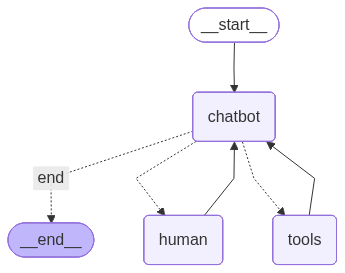

In [17]:
chat_graph

In [18]:
if __name__ == "__main__":
  print("=" * 60)
  print("MT COFFEE SHOP CHATBOT")
  print("=" * 60)
  print("Nhập 'q', 'quit', 'exit', hoặc 'tạm biệt' để thoát\n")
  
  state = {
    "messages": [],
    "customer_id": "CUST_001",
    "finished": False
  }
  
  try:
    chat_graph.invoke(state)
  except KeyboardInterrupt:
    print("\n\nChatbot stopped by user")
  except Exception as e:
    print(f"\nError: {e}")
    import traceback
    traceback.print_exc()

MT COFFEE SHOP CHATBOT
Nhập 'q', 'quit', 'exit', hoặc 'tạm biệt' để thoát

Welcome message sent
HUMAN

Assistant: Chào mừng bạn đã đến với của hàng MT' Coffee của chúng tôi, không biết tôi có thể giúp gì được cho bạn nhỉ?

Sending 2 messages to LLM...
LLM requested 1 tool call(s):
      - hand_customer_query: {'query': 'cà phê'}
TOOLS (1 call(s))
Sending 4 messages to LLM...
LLM response: Quán chúng tôi có nhiều loại cà phê cho bạn lựa chọn như Cà phê phin, Espresso, A-Mê, Cà phê máy và ...
HUMAN

Assistant: Quán chúng tôi có nhiều loại cà phê cho bạn lựa chọn như Cà phê phin, Espresso, A-Mê, Cà phê máy và Cold Brew. Bạn có muốn thử một trong số đó không?

Sending 6 messages to LLM...
LLM response: Quán chúng tôi có nhiều loại Matcha như Matcha Latte, Matcha Green Tea, và Matcha Mousse. Mỗi loại đ...
HUMAN

Assistant: Quán chúng tôi có nhiều loại Matcha như Matcha Latte, Matcha Green Tea, và Matcha Mousse. Mỗi loại đều mang hương vị độc đáo của matcha kết hợp với các topping khác nhau.